In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

In [ ]:
#Logistic Regression
df = pd.read_parquet('./dataset/yelp_academic_dataset_business_cleaned.parquet')

cols = [
    'stars', 'review_count', 'latitude', 'longitude',
    'Alcohol', 'BikeParking', 'RestaurantsDelivery', 
    'RestaurantsTakeOut', 'RestaurantsPriceRange2'
]
df = df[cols]

# Converter colunas categóricas
df['Alcohol'] = df['Alcohol'].map({'None': 0, 'Beer&Wine': 1, 'Full_Bar': 2, 'Unknown': 1})
df['BikeParking'] = df['BikeParking'].fillna(0).astype(int)
df['RestaurantsDelivery'] = df['RestaurantsDelivery'].map({'True': 1, 'False': 0, 'Unknown': 0})
df['RestaurantsTakeOut'] = df['RestaurantsTakeOut'].map({'True': 1, 'False': 0, 'Unknown': 0})

df = df.dropna(subset=['RestaurantsPriceRange2'])

X = df.drop('RestaurantsPriceRange2', axis=1)
y = df['RestaurantsPriceRange2'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
print(y_test.value_counts())  # Antes e depois do balanceamento

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), ['stars', 'review_count', 'latitude', 'longitude']),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('passthrough', 'passthrough')
        ]), ['Alcohol', 'BikeParking', 'RestaurantsDelivery', 'RestaurantsTakeOut'])
    ]
)

pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=1)),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=1))
])


RestaurantsPriceRange2
2    21001
1     7476
3     1334
4      238
Name: count, dtype: int64


In [77]:
y_train_bin = label_binarize(y_train, classes=[1, 2, 3, 4])
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])

pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=1)))
])

pipeline.fit(X_train, y_train_bin)

y_pred = pipeline.predict(X_test)
y_probs = pipeline.predict_proba(X_test)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


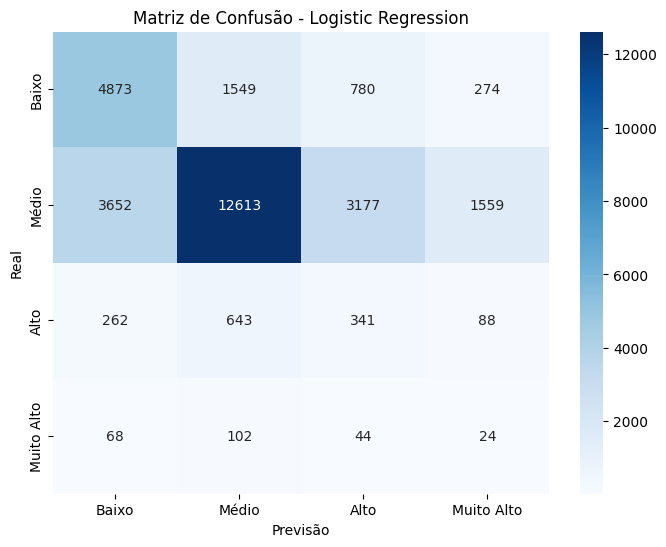

Relatório de Classificação (Logistic Regression):
              precision    recall  f1-score   support

           1       0.55      0.65      0.60      7476
           2       0.85      0.60      0.70     21001
           3       0.08      0.26      0.12      1334
           4       0.01      0.10      0.02       238

    accuracy                           0.59     30049
   macro avg       0.37      0.40      0.36     30049
weighted avg       0.73      0.59      0.64     30049



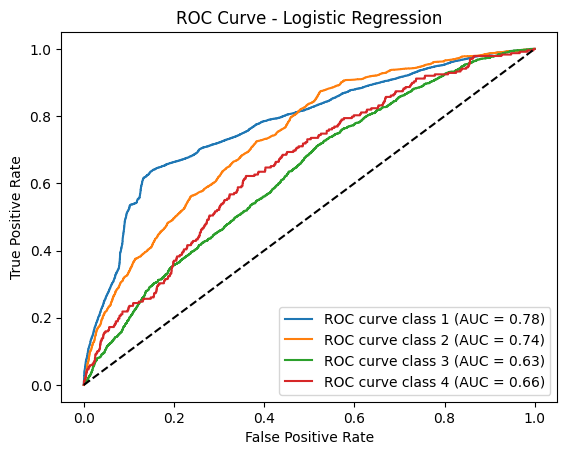

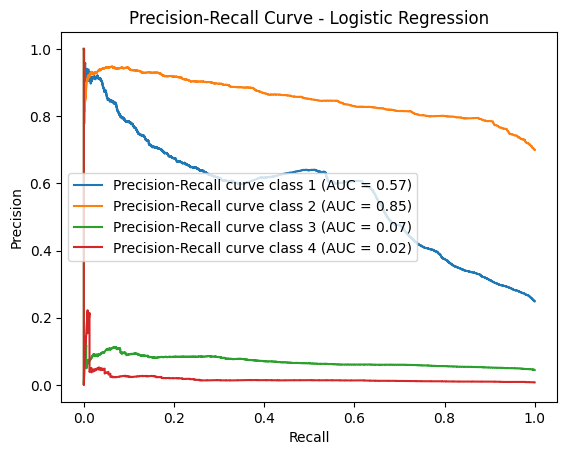

RestaurantsPriceRange2
2    21001
1     7476
3     1334
4      238
Name: count, dtype: int64


In [78]:
cm = confusion_matrix(y_test, y_pred.argmax(axis=1) + 1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixo', 'Médio', 'Alto', 'Muito Alto'], yticklabels=['Baixo', 'Médio', 'Alto', 'Muito Alto'])
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Logistic Regression')
plt.show()

print("Relatório de Classificação (Logistic Regression):")
print(classification_report(y_test, y_pred.argmax(axis=1) + 1))

# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve class {i+1} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

# Precision-Recall Curve
precision = dict()
recall = dict()
pr_auc = dict()
for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_probs[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

plt.figure()
for i in range(4):
    plt.plot(recall[i], precision[i], label=f'Precision-Recall curve class {i+1} (AUC = {pr_auc[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression')
plt.legend()
plt.show()
print(y_test.value_counts())  # Antes e depois do balanceamento


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


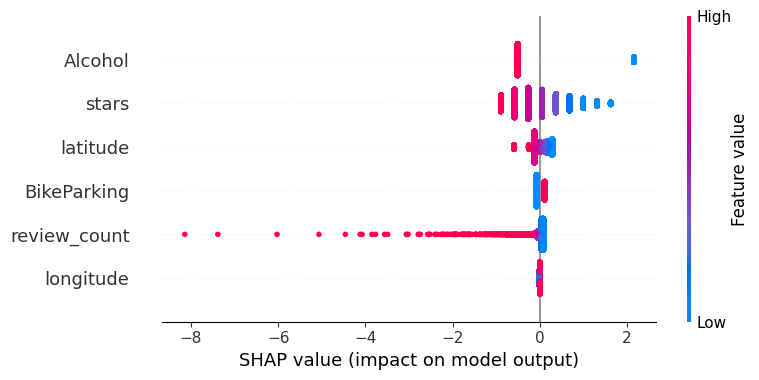

SHAP values for class 1:


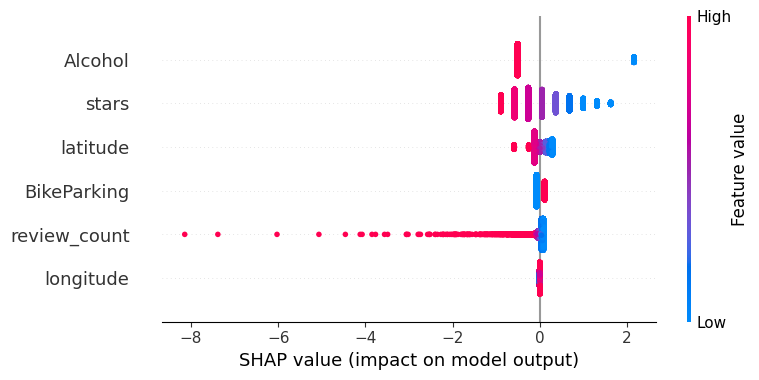

SHAP values for class 2:


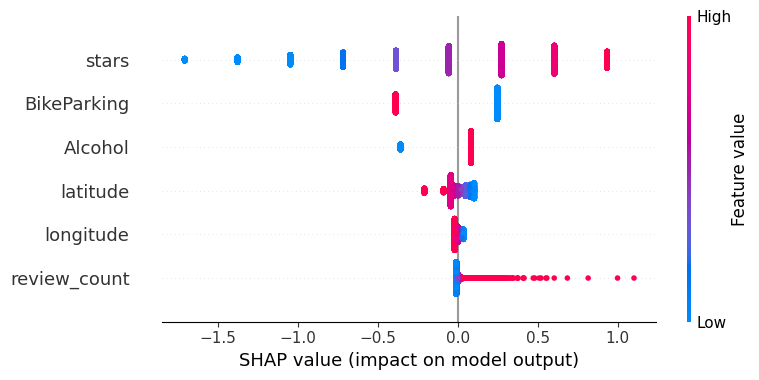

SHAP values for class 3:


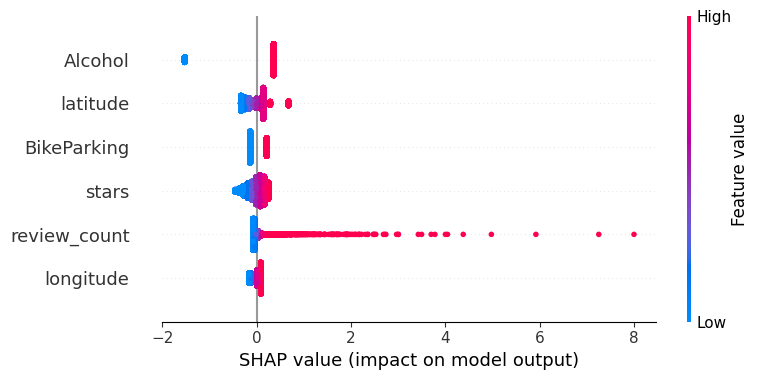

SHAP values for class 4:


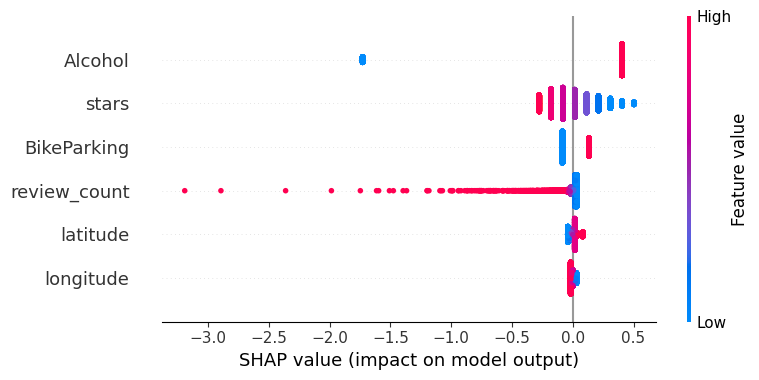

In [59]:
import shap

# 1. Aplicar o pré-processamento
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

# 2. Acessar o modelo de Regressão Logística subjacente
logistic_model = pipeline.named_steps['classifier'].estimators_[0]

# 3. Criar o explainer
explainer = shap.LinearExplainer(logistic_model, X_train_transformed)

# 4. Calcular os valores de SHAP
shap_values = explainer.shap_values(X_test_transformed)

# 5. Visualizar o gráfico de resumo
shap.summary_plot(shap_values, X_test_transformed, feature_names=X.columns)
for i, model in enumerate(pipeline.named_steps['classifier'].estimators_):
    explainer = shap.LinearExplainer(model, X_train_transformed)
    shap_values = explainer.shap_values(X_test_transformed)
    print(f"SHAP values for class {i+1}:")
    shap.summary_plot(shap_values, X_test_transformed, feature_names=X.columns)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


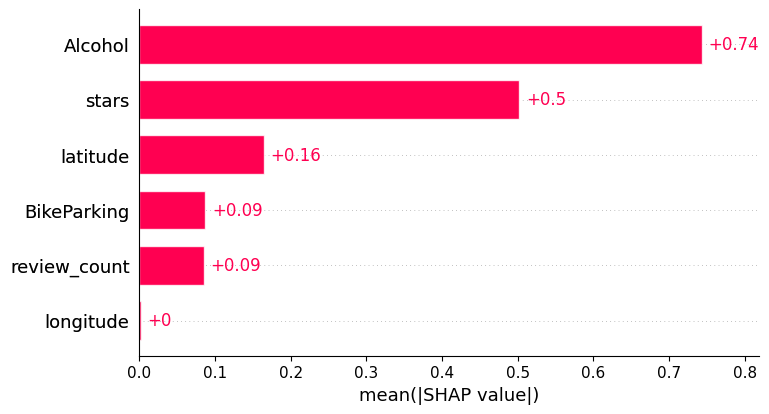

In [ ]:
import shap

#FEATURE IMPORTANCE
# 1. Aplicar o pré-processamento
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

# 2. Acessar o modelo de Regressão Logística subjacente
logistic_model = pipeline.named_steps['classifier'].estimators_[0]

# 3. Criar o explainer
explainer = shap.LinearExplainer(logistic_model, X_train_transformed)

# 4. Calcular os valores de SHAP
shap_values = explainer.shap_values(X_test_transformed)

# 5. Criar um objeto Explanation para usar no bar plot
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test_transformed,
    feature_names=X.columns
)

# 6. Criar um bar plot com os valores de SHAP
shap.plots.bar(shap_explanation)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


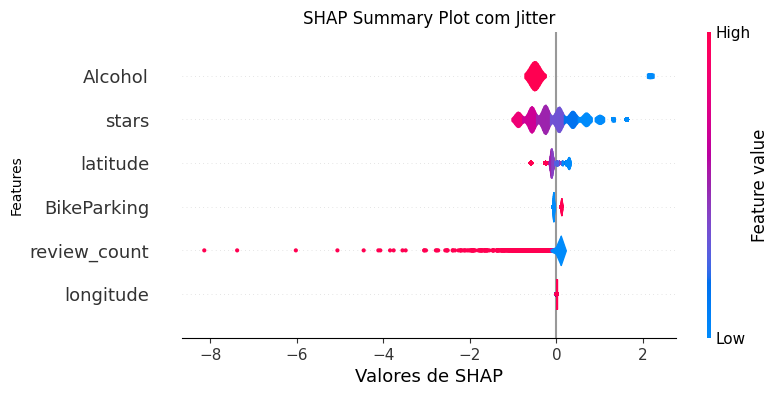

In [34]:
import shap
import matplotlib.pyplot as plt

# 1. Aplicar o pré-processamento
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

# 2. Acessar o modelo de Regressão Logística subjacente
logistic_model = pipeline.named_steps['classifier'].estimators_[0]

# 3. Criar o explainer
explainer = shap.LinearExplainer(logistic_model, X_train_transformed)

# 4. Calcular os valores de SHAP
shap_values = explainer.shap_values(X_test_transformed)

# 5. Visualizar o gráfico de resumo com jitter
shap.summary_plot(
    shap_values, 
    X_test_transformed, 
    feature_names=X.columns,
    plot_type="violin",  # Usar "violin" ou "layered_violin" para adicionar jitter
    show=False  # Evita a exibição automática para personalização
)

# Personalizar o gráfico
plt.title("SHAP Summary Plot com Jitter")
plt.xlabel("Valores de SHAP")
plt.ylabel("Features")
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_11100\1136553135.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['RestaurantsDelivery'].fillna(0, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_11100\1136553135.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['RestaurantsDelivery'].fillna(0, inplace=True)
C:\Users\User\AppData

Melhores Parâmetros: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Relatório de Classificação (com melhores parâmetros):
              precision    recall  f1-score   support

         1.0       0.48      0.56      0.52      7476
         2.0       0.80      0.65      0.72     21001
         3.0       0.08      0.19      0.11      1334
         4.0       0.02      0.08      0.03       238

    accuracy                           0.60     30049
   macro avg       0.34      0.37      0.34     30049
weighted avg       0.68      0.60      0.63     30049

Acurácia (com melhores parâmetros): 0.6000199673866019


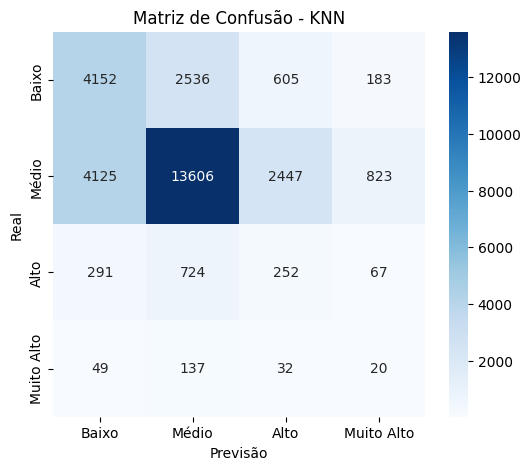

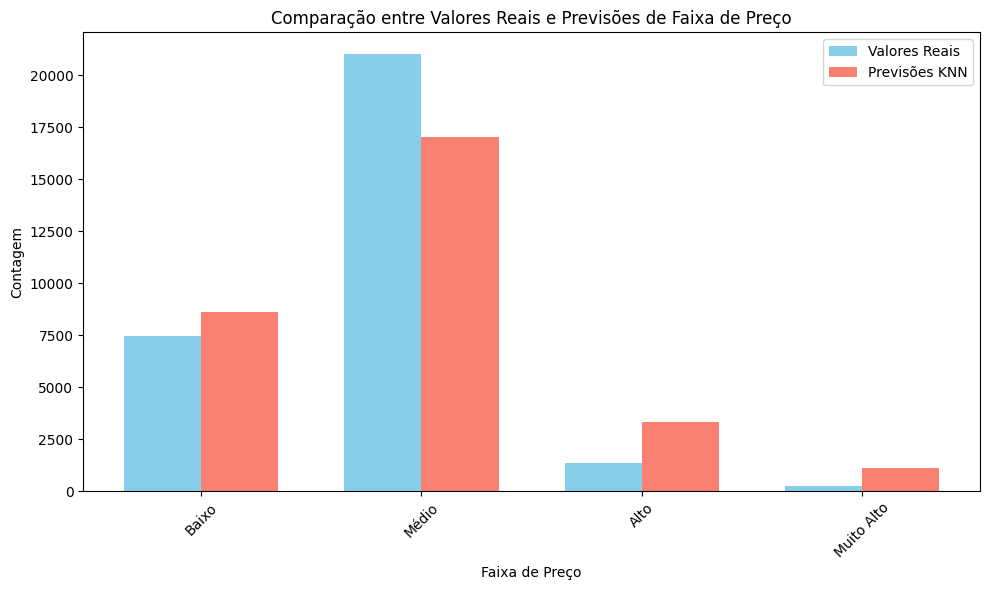

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# Carregar o dataset
df_negocios = pd.read_parquet('./dataset/yelp_academic_dataset_business_cleaned.parquet')

# Definir as features e target
features = ['stars', 'review_count', 'latitude', 'longitude', 'city', 'RestaurantsDelivery', 'RestaurantsTakeOut']
X = df_negocios[features]
y = df_negocios['RestaurantsPriceRange2']

# Tratamento de valores nulos
X['RestaurantsDelivery'].fillna(0, inplace=True)
X['RestaurantsTakeOut'].fillna(0, inplace=True)

# Codificação da coluna categórica 'city'
label_encoder = LabelEncoder()
X['city'] = label_encoder.fit_transform(X['city'])

# Normalização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=1)

# Aplicação de SMOTE no conjunto de treino
smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Modelo KNN
knn = KNeighborsClassifier()

# Definição dos hiperparâmetros para GridSearch
param_grid = {
    'n_neighbors': [3, 5, 10, 15, 20, 30, 50],  
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan']  
}

# GridSearch com validação cruzada
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Melhor modelo e avaliação
print("Melhores Parâmetros:", grid_search.best_params_)
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

print("Relatório de Classificação (com melhores parâmetros):")
print(classification_report(y_test, y_pred))
print("Acurácia (com melhores parâmetros):", accuracy_score(y_test, y_pred))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
labels = ['Baixo', 'Médio', 'Alto', 'Muito Alto']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusão - KNN")
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.show()

# Comparação entre valores reais e previsões
real_counts = y_test.value_counts()
pred_counts = pd.Series(y_pred).value_counts()

plt.figure(figsize=(10, 6))
width = 0.35 
plt.bar(real_counts.index - width/2, real_counts, width=width, label='Valores Reais', color='skyblue')
plt.bar(pred_counts.index + width/2, pred_counts, width=width, label='Previsões KNN', color='salmon')
plt.title("Comparação entre Valores Reais e Previsões de Faixa de Preço")
plt.xlabel("Faixa de Preço")
plt.ylabel("Contagem")
plt.xticks(range(1, 5), labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Melhores Parâmetros: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Relatório de Classificação (com melhores parâmetros):
              precision    recall  f1-score   support

         1.0       0.41      0.46      0.43     11251
         2.0       0.77      0.63      0.69     31468
         3.0       0.07      0.19      0.10      1998
         4.0       0.01      0.06      0.02       356

    accuracy                           0.56     45073
   macro avg       0.32      0.33      0.31     45073
weighted avg       0.65      0.56      0.60     45073

Acurácia (com melhores parâmetros):
0.5599361036540723


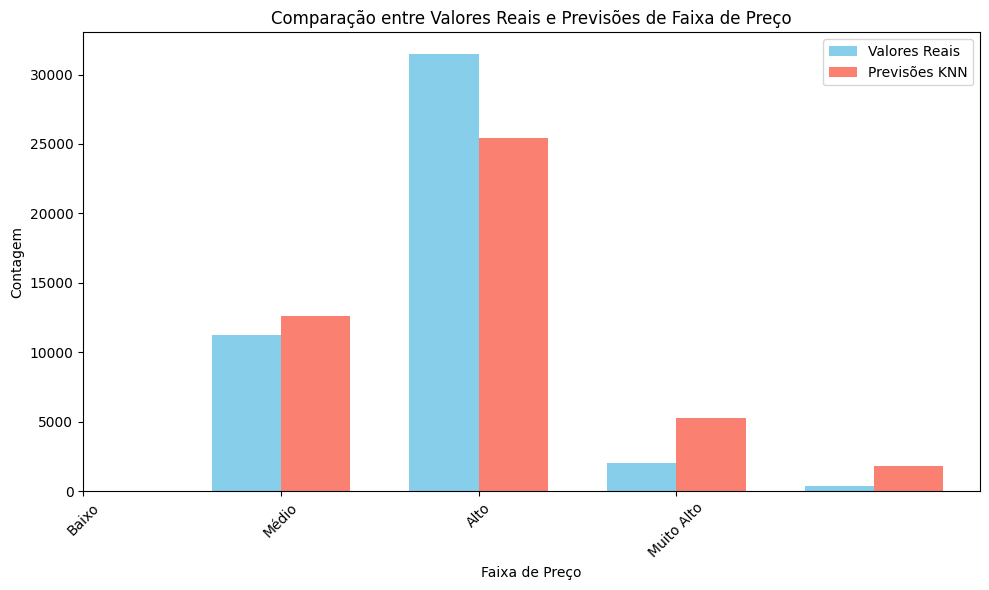

In [ ]:
# Modelo Knn

knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 10, 15, 20, 30, 50],  
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan']  
}

# Realizar GridSearch com validação cruzada
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

print("Melhores Parâmetros:", grid_search.best_params_)
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)
print("Relatório de Classificação (com melhores parâmetros):")
print(classification_report(y_test, y_pred))
print("Acurácia (com melhores parâmetros):")
print(accuracy_score(y_test, y_pred))

# Gráfico de comparação entre valores reais e previsões
real_counts = y_test.value_counts()
pred_counts = pd.Series(y_pred).value_counts()

labels = ['Baixo', 'Médio', 'Alto', 'Muito Alto']
width = 0.35 
plt.figure(figsize=(10, 6))

plt.bar(real_counts.index - width/2, real_counts, width=width, label='Valores Reais', color='skyblue')
plt.bar(pred_counts.index + width/2, pred_counts, width=width, label='Previsões KNN', color='salmon')
plt.title("Comparação entre Valores Reais e Previsões de Faixa de Preço")
plt.xlabel("Faixa de Preço")
plt.ylabel("Contagem")
plt.xticks(range(4), labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


Relatório de Classificação (Random Forest):
              precision    recall  f1-score   support

           1       0.66      0.60      0.63      7476
           2       0.85      0.64      0.73     21001
           3       0.09      0.30      0.14      1334
           4       0.02      0.20      0.03       238

    accuracy                           0.61     30049
   macro avg       0.40      0.44      0.38     30049
weighted avg       0.76      0.61      0.67     30049

Acurácia (Random Forest): 0.6109687510399681


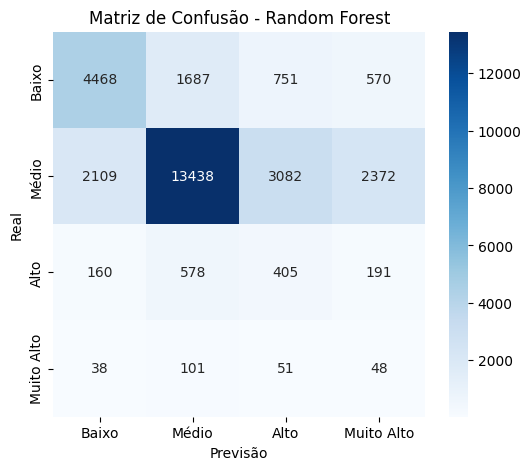

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Carregar o dataset
df = pd.read_parquet('./dataset/yelp_academic_dataset_business_cleaned.parquet')

# Seleção de colunas
cols = ['stars', 'review_count', 'latitude', 'longitude',
        'Alcohol', 'BikeParking', 'RestaurantsDelivery', 'RestaurantsTakeOut', 'RestaurantsPriceRange2']
df = df[cols]

# Converter colunas categóricas
df['Alcohol'] = df['Alcohol'].map({'None': 0, 'Beer&Wine': 1, 'Full_Bar': 2, 'Unknown': 1})
df['BikeParking'] = df['BikeParking'].fillna(0).astype(int)
df['RestaurantsDelivery'] = df['RestaurantsDelivery'].map({'True': 1, 'False': 0, 'Unknown': 0})
df['RestaurantsTakeOut'] = df['RestaurantsTakeOut'].map({'True': 1, 'False': 0, 'Unknown': 0})

df = df.dropna(subset=['RestaurantsPriceRange2'])

# Separação entre features e target
X = df.drop('RestaurantsPriceRange2', axis=1)
y = df['RestaurantsPriceRange2'].astype(int)

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# Pré-processamento
data_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), ['stars', 'review_count', 'latitude', 'longitude']),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent'))
        ]), ['Alcohol', 'BikeParking', 'RestaurantsDelivery', 'RestaurantsTakeOut'])
    ]
)

# Definição do pipeline com Random Forest
rf_pipeline = ImbPipeline([
    ('preprocessor', data_preprocessor),
    ('smote', SMOTE(random_state=1)),
    ('classifier', RandomForestClassifier(
        n_estimators=200, 
        max_depth=15, 
        min_samples_split=5, 
        min_samples_leaf=2, 
        bootstrap=True, 
        max_features='sqrt', 
        class_weight='balanced', 
        random_state=1
    ))
])

# Treinamento do modelo
rf_pipeline.fit(X_train, y_train)

# Predições
y_pred = rf_pipeline.predict(X_test)

# Avaliação do modelo
print("Relatório de Classificação (Random Forest):")
print(classification_report(y_test, y_pred))
print("Acurácia (Random Forest):", accuracy_score(y_test, y_pred))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
labels = ['Baixo', 'Médio', 'Alto', 'Muito Alto']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusão - Random Forest")
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.show()


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:11:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


Relatório de Classificação (XGBoost):
              precision    recall  f1-score   support

           0       0.65      0.62      0.63      7476
           1       0.84      0.76      0.79     21001
           2       0.11      0.28      0.16      1334
           3       0.03      0.07      0.04       238

    accuracy                           0.70     30049
   macro avg       0.41      0.43      0.41     30049
weighted avg       0.75      0.70      0.72     30049

Acurácia (XGBoost): 0.6957968651203035


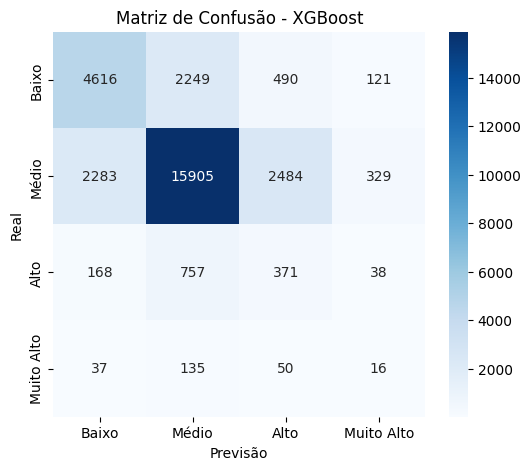

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Carregar o dataset
df = pd.read_parquet('./dataset/yelp_academic_dataset_business_cleaned.parquet')

# Seleção de colunas
cols = ['stars', 'review_count', 'latitude', 'longitude',
        'Alcohol', 'BikeParking', 'RestaurantsDelivery', 'RestaurantsTakeOut', 'RestaurantsPriceRange2']
df = df[cols]

# Converter colunas categóricas
df['Alcohol'] = df['Alcohol'].map({'None': 0, 'Beer&Wine': 1, 'Full_Bar': 2, 'Unknown': 1})
df['BikeParking'] = df['BikeParking'].fillna(0).astype(int)
df['RestaurantsDelivery'] = df['RestaurantsDelivery'].map({'True': 1, 'False': 0, 'Unknown': 0})
df['RestaurantsTakeOut'] = df['RestaurantsTakeOut'].map({'True': 1, 'False': 0, 'Unknown': 0})

df = df.dropna(subset=['RestaurantsPriceRange2'])

# Separação entre features e target
X = df.drop('RestaurantsPriceRange2', axis=1)
y = df['RestaurantsPriceRange2'].astype(int)
y=y-1
# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# Pré-processamento
data_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), ['stars', 'review_count', 'latitude', 'longitude']),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent'))
        ]), ['Alcohol', 'BikeParking', 'RestaurantsDelivery', 'RestaurantsTakeOut'])
    ]
)

# Definição do pipeline com XGBoost
xgb_pipeline = ImbPipeline([
    ('preprocessor', data_preprocessor),
    ('smote', SMOTE(random_state=1)),
    ('classifier', XGBClassifier(
        n_estimators=200, 
        max_depth=6, 
        learning_rate=0.1, 
        subsample=0.8, 
        colsample_bytree=0.8, 
        scale_pos_weight=1, 
        random_state=1
    ))
])

# Treinamento do modelo
xgb_pipeline.fit(X_train, y_train)

# Predições
y_pred = xgb_pipeline.predict(X_test)

# Avaliação do modelo
print("Relatório de Classificação (XGBoost):")
print(classification_report(y_test, y_pred))
print("Acurácia (XGBoost):", accuracy_score(y_test, y_pred))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
labels = ['Baixo', 'Médio', 'Alto', 'Muito Alto']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusão - XGBoost")
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.show()


Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:48:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Melhores hiperparâmetros encontrados: {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 300, 'classifier__scale_pos_weight': 3, 'classifier__subsample': 1.0}
Relatório de Classificação (XGBoost com GridSearch):
              precision    recall  f1-score   support

           0       0.65      0.61      0.63      7476
           1       0.83      0.78      0.81     21001
           2       0.11      0.23      0.15      1334
           3       0.03      0.05      0.03       238

    accuracy                           0.71     30049
   macro avg       0.40      0.42      0.40     30049
weighted avg       0.75      0.71      0.73     30049

Acurácia (XGBoost com GridSearch): 0.7095743618756032


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


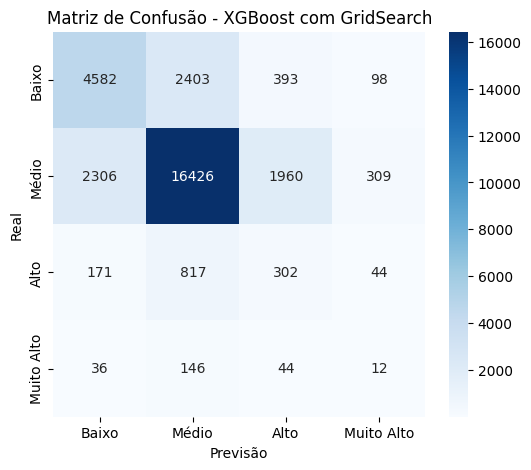

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Carregar o dataset
df = pd.read_parquet('./dataset/yelp_academic_dataset_business_cleaned.parquet')

# Seleção de colunas
cols = ['stars', 'review_count', 'latitude', 'longitude',
        'Alcohol', 'BikeParking', 'RestaurantsDelivery', 'RestaurantsTakeOut', 'RestaurantsPriceRange2']
df = df[cols]

# Converter colunas categóricas
df['Alcohol'] = df['Alcohol'].map({'None': 0, 'Beer&Wine': 1, 'Full_Bar': 2, 'Unknown': 1})
df['BikeParking'] = df['BikeParking'].fillna(0).astype(int)
df['RestaurantsDelivery'] = df['RestaurantsDelivery'].map({'True': 1, 'False': 0, 'Unknown': 0})
df['RestaurantsTakeOut'] = df['RestaurantsTakeOut'].map({'True': 1, 'False': 0, 'Unknown': 0})

df = df.dropna(subset=['RestaurantsPriceRange2'])

# Separação entre features e target
X = df.drop('RestaurantsPriceRange2', axis=1)
y = df['RestaurantsPriceRange2'].astype(int)
y = y - 1  # Ajustar para 0, 1, 2, 3

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# Pré-processamento
data_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), ['stars', 'review_count', 'latitude', 'longitude']),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent'))
        ]), ['Alcohol', 'BikeParking', 'RestaurantsDelivery', 'RestaurantsTakeOut'])
    ]
)

# Definição do pipeline com XGBoost
xgb_pipeline = ImbPipeline([
    ('preprocessor', data_preprocessor),
    ('smote', SMOTE(random_state=1)),
    ('classifier', XGBClassifier(random_state=1))  # Inicia com o XGBoost básico
])

# Definir os hiperparâmetros para o GridSearch
param_grid = {
    'classifier__n_estimators': [300],
    'classifier__max_depth': [ 7, 10],
    'classifier__learning_rate': [ 0.2],
    'classifier__subsample': [0.5, 1.0],
    'classifier__colsample_bytree': [0.6, 1.0],
    'classifier__scale_pos_weight': [3]  # Ajustar peso da classe positiva
}

# Criar o GridSearchCV com validação cruzada
grid_search = GridSearchCV(estimator=xgb_pipeline, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Treinar o modelo usando GridSearch
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
print("Melhores hiperparâmetros encontrados:", grid_search.best_params_)

# Avaliação do modelo com os melhores hiperparâmetros
y_pred = grid_search.predict(X_test)

# Relatório de Classificação
print("Relatório de Classificação (XGBoost com GridSearch):")
print(classification_report(y_test, y_pred))
print("Acurácia (XGBoost com GridSearch):", accuracy_score(y_test, y_pred))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
labels = ['Baixo', 'Médio', 'Alto', 'Muito Alto']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusão - XGBoost com GridSearch")
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.show()
